## <b><u>Section 01:-</u> Import Libraries & Data</b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data=pd.read_csv("airline-passenger-traffic.csv")
data.columns=['Month','Passengers']
data['Month']=pd.to_datetime(data['Month'],format='%Y-%m')
data=data.set_index('Month')
data.head(5)

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


## <b><u>Section 02:-</u> Data Cleaning & EDA</b>

### <b><u>Part 01:-</u> Checking for the missing value present & Treating them</b>

In [ ]:

total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['No of Missing Values', 'Percent']).transpose()

,Passengers
No of Missing Values,4.000000
Percent,2.797203


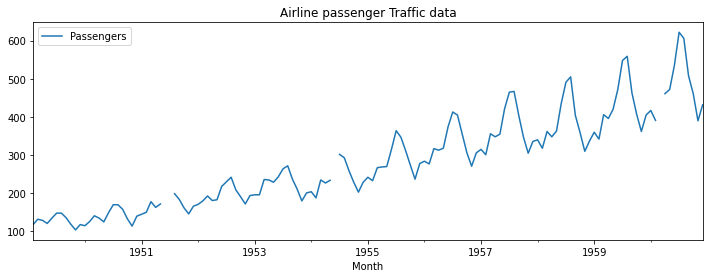

In [ ]:
data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("Airline passenger Traffic data")
plt.show(block=False)

#### <b><u>Method 01:-</u> Mean Imputation</b>

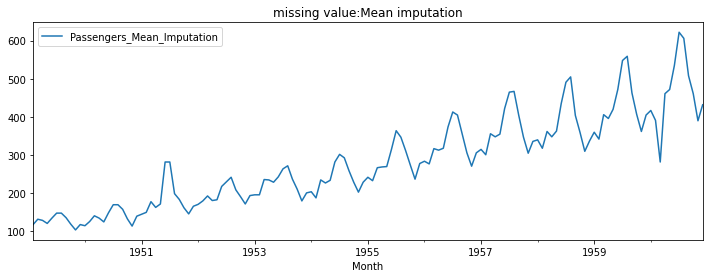

In [ ]:
data=data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("missing value:Mean imputation")
plt.show(block=False)


#### <b><u>Method 02:-</u> Linear Interpolation Imputation</b>

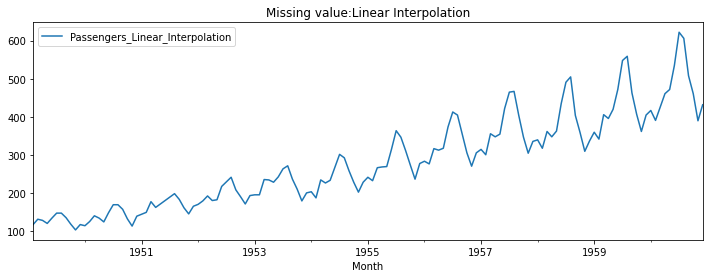

In [ ]:
data=data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("Missing value:Linear Interpolation")
plt.show(block=False)


#### <b><u>Conclusion:-</u> Using Method 02 linear interpolation to impute missing value</b>

In [ ]:
data['Passengers']=data['Passengers_Linear_Interpolation']

### <b><u>Part 02:-</u> Outlier Detection </b>

count    143.000000
mean     281.510490
std      119.633411
min      104.000000
25%      181.000000
50%      268.000000
75%      361.000000
85%      411.200000
90%      455.800000
100%     622.000000
max      622.000000
Name: Passengers, dtype: float64


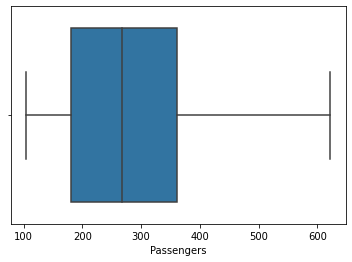

In [ ]:
print(data.Passengers.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))
sns.boxplot(x='Passengers',data=data)

In [ ]:
df_outlier=data[['Passengers']]

Q1 = df_outlier.quantile(0.25)
Q3 = df_outlier.quantile(0.75)
IQR = Q3 - Q1
print("IQR is:-",IQR)

print("Number of Outliers:-",((df_outlier < (Q1 - 1.5 * IQR)) | (df_outlier > (Q3 + 1.5 * IQR))).sum())

IQR is:- Passengers    180.0
dtype: float64
Number of Outliers:- Passengers    0
dtype: int64


### <b><u>Part 03:-</u> Time Series Decomposition </b>

#### <b> Additive seasonal decomposition </b>

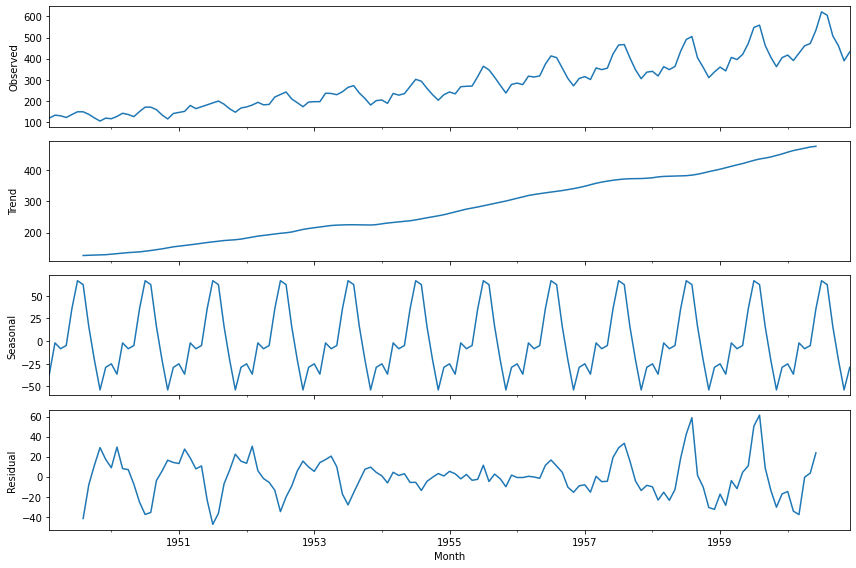

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize']=12,8
decomposition=sm.tsa.seasonal_decompose(data.Passengers,model='additive')
fig=decomposition.plot()

### <b> Multiplicative Seasonal Decomposition</b>

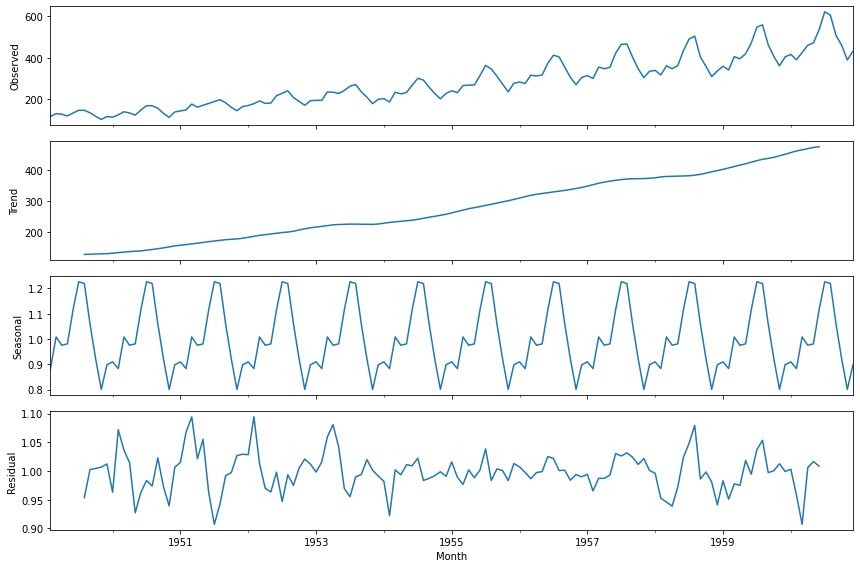

In [ ]:
decomposition=sm.tsa.seasonal_decompose(data.Passengers,model='multiplicative')
fig=decomposition.plot()

## <b><u>Section 03:-</u> Build Evaluate time series forcast</b>

### <b> Splitting time series into Training and Test sets</b>

In [ ]:
train_len=120
train=data[:train_len]
test=data[train_len:]

### <b>Different Forecasting Methods</b>

#### <b><u>Method 01:-</u> Naive Method </b>

In [ ]:
y_hat_naive=test.copy()
y_hat_naive['naive_forecast']=train['Passengers'][train_len-1]

##### <b> Plot Train,test Forcast</b>

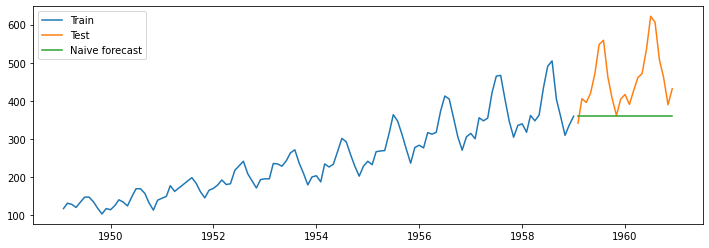

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_naive['naive_forecast'],label='Naive forecast')
plt.legend(loc='best')

##### <b> Calculate RMSE and MAPE to evaluate forecast On Naive Method </b>

In [ ]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_naive['naive_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results=pd.DataFrame({'Method':['Naive method'],'Mape':[mape],'RMSE':[rmse]})
results=results[['Method','RMSE','Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.4,19.68


#### <b><u>METHOD 02:-</u> Sime Average Method </b>

In [ ]:
y_hat_avg=test.copy()
y_hat_avg['avg_forecast']=train['Passengers'].mean()

##### <b> Plot Train,test and Forcast</b>

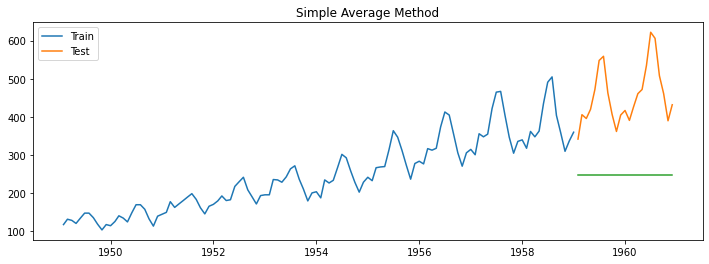

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_avg['avg_forecast'])
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple Average Method(Sime) </b>

In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_avg['avg_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Average Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.4,19.68
0,Simple Average Method,221.2,44.36


#### <b><u>Method 03:-</u>Simple Moving Average Method</b>

In [ ]:
y_hat_sma=data.copy()
ma_windows=12
y_hat_sma['sma_forecast']=data['Passengers'].rolling(ma_windows).mean()
y_hat_sma['sma_forecast'][train_len:]=y_hat_sma['sma_forecast'][train_len-1]

##### <b> Plot,train, test and forecast </b>

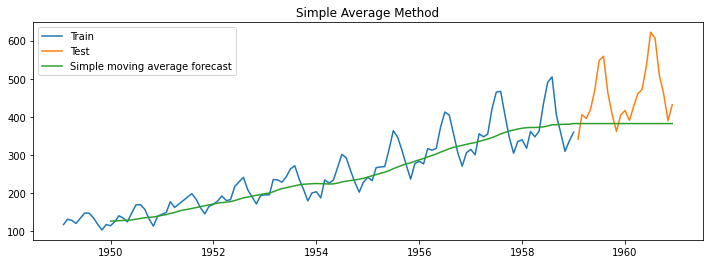

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple Moving Average Method(Sime) </b>

In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_sma['sma_forecast'][train_len:])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Moving Average Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67


#### <b><u>Method 04:-</u>Simple Exponential Smoothing Method</b>

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model=SimpleExpSmoothing(train['Passengers'])
model_fit=model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses=test.copy()
y_hat_ses['ses_forecast']=model_fit.forecast(24)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### <b>Plot Train,test and forecast</b>

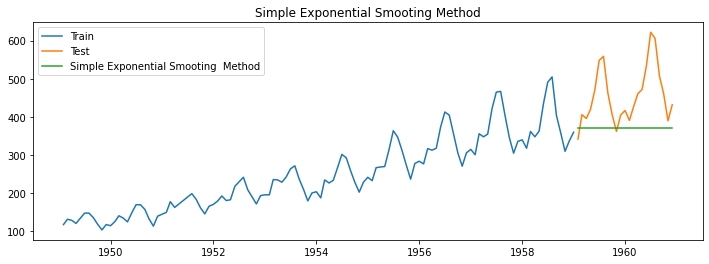

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_ses['ses_forecast'],label='Simple Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Simple Exponential Smooting Method')
plt.show()


##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple exponential smoothing method </b>

In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_ses['ses_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Exponential Smoothing Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55


#### <b><u>Method 04:-</u>Holt Exponential Smoothing Method</b>

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model= ExponentialSmoothing(np.array(train['Passengers']),seasonal_periods=12,trend='additive')
model_fit=model.fit(smoothing_level=0.2,smoothing_slope=0.01,optimized=False)
print(model_fit.params)

y_hat_holt=test.copy()
y_hat_holt['holt_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 118.0, 'initial_slope': 14.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### <b>Plot Train,test and forecast</b>

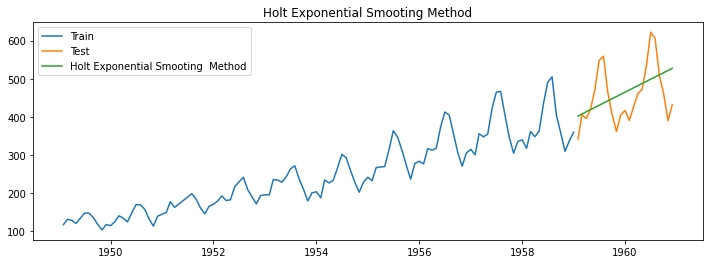

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_holt['holt_forecast'],label='Holt Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Holt Exponential Smooting Method')
plt.show()


##### <b> Calculate RMSE and MAPE to evaluate forecast On Holt Exponential Smoothing Method </b>

In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_holt['holt_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Exponential Smoothing Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75


#### <b><u>Method 05:-</u>Holt Winter's Exponential Smoothing Additive & Multiplicative Method</b>

##### <b><u>Type 01:-</u>Holt Winter's Exponential Smoothing Additive Method</b>

In [ ]:
y_hat_hwa=test.copy()
model= ExponentialSmoothing(np.array(train['Passengers']),seasonal_periods=12,trend='add',seasonal='add')

model_fit=model.fit(optimized=True)
print(model_fit.params)

y_hat_hwa['hwa_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.2631578925350555, 'smoothing_slope': 0.050534814398665674, 'smoothing_seasonal': 0.7368421030613712, 'damping_slope': nan, 'initial_level': 206.84464215928838, 'initial_slope': 2.0943208438897747, 'initial_seasons': array([ -90.22523269,  -76.406035  ,  -79.66930346,  -87.75805964,
        -73.74482738,  -60.81774253,  -61.01332787,  -73.21637721,
        -90.37116428, -105.25649431,  -90.91910777,  -93.85787412]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


###### <b>Plot Train,test and forecast</b>

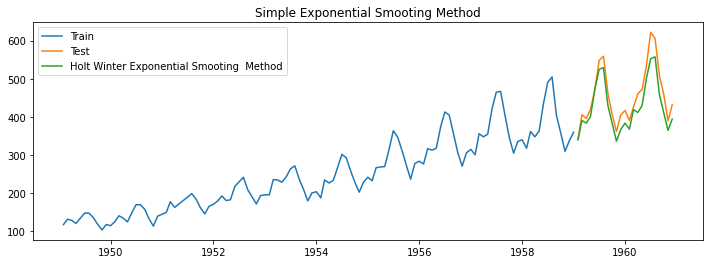

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_hwa['hwa_forecast'],label='Holt Winter Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Simple Exponential Smooting Method')
plt.show()


###### <b> Calculate RMSE and MAPE to evaluate forecast On Holt winters Additive Method </b>

In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwa['hwa_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Winters\' Additive Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37


##### <b><u>Type 02:-</u>Holt Winter's Exponential Smoothing Multiplicative Method</b>

In [ ]:
y_hat_hwm=test.copy()
model= ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12,trend='add',seasonal='mul')

model_fit=model.fit(optimized=True)
print(model_fit.params)

y_hat_hwm['hwm_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.3157894736526667, 'smoothing_slope': 0.05263126447168534, 'smoothing_seasonal': 0.6842105262842456, 'damping_slope': nan, 'initial_level': 208.69981154945813, 'initial_slope': 1.271244348561395, 'initial_seasons': array([0.58965376, 0.64430462, 0.61485636, 0.56784817, 0.63010543,
       0.69306308, 0.69284049, 0.63396818, 0.55133878, 0.48738474,
       0.56998034, 0.56536063]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


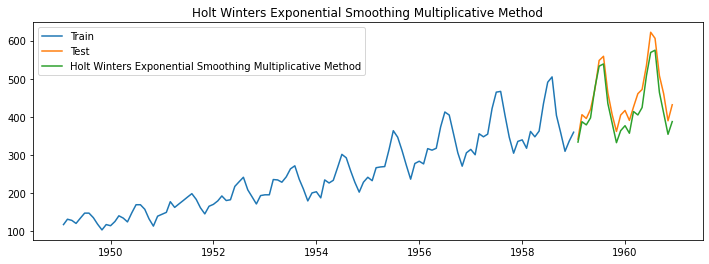

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_hwm['hwm_forecast'],label='Holt Winters Exponential Smoothing Multiplicative Method')
plt.legend(loc='best')
plt.title('Holt Winters Exponential Smoothing Multiplicative Method')
plt.show()


In [ ]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwm['hwm_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Winters\' Multiplicative Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
